In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Data Visualization
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

#Sharpening of images
from skimage.io import imshow, imread
from skimage.color import rgb2yuv, rgb2hsv, rgb2gray, yuv2rgb, hsv2rgb
from scipy.signal import convolve2d

#Preprocessing of Images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#Buliding Model
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

#Accuracy
from sklearn.metrics import classification_report


In [ ]:
data_dir = '/content/drive/MyDrive/third_dataset'
categories = os.listdir(data_dir)

In [ ]:
categories=sorted(categories)
print(categories)

['Healthy', 'RedRot', 'RedRust']


In [ ]:
labels=[i for i in range(len(categories))]
labels

[0, 1, 2]

In [ ]:
label_dict=dict(zip(categories, labels))
label_dict

{'Healthy': 0, 'RedRot': 1, 'RedRust': 2}

In [ ]:
data_list=[] #data_list- storing the images
labels_list=[] #label_list - storing the class labels


In [ ]:
data1="/content/drive/MyDrive/third_dataset/Healthy"
data2="/content/drive/MyDrive/third_dataset/RedRot"
data3="/content/drive/MyDrive/third_dataset/RedRust"
count_healthy=0
count_redrot=0
count_redrust=0

In [ ]:
for i in os.listdir(data1):
        img_path=os.path.join(data1, i)
        count_healthy=count_healthy+1

In [ ]:
for i in os.listdir(data2):
        img_path=os.path.join(data2, i)
        count_redrot=count_redrot+1

In [ ]:
for i in os.listdir(data3):
        img_path=os.path.join(data3, i)
        count_redrust=count_redrust+1

In [ ]:
count_healthy,count_redrot,count_redrust

(522, 518, 514)

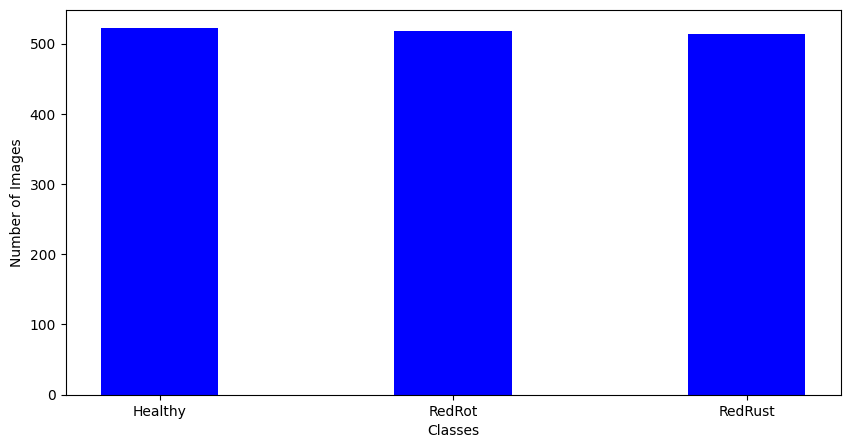

In [ ]:
fig = plt.figure(figsize = (10, 5))
classes=["Healthy","RedRot", "RedRust"]
values=[count_healthy,count_redrot,count_redrust]
#creating the bar plot
plt.bar(classes, values, color ='blue',
        width = 0.4)

plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.show()

In [ ]:
sharpen = np.array([[0, -1, 0],
                    [-1, 5, -1],
                    [0, -1, 0]])

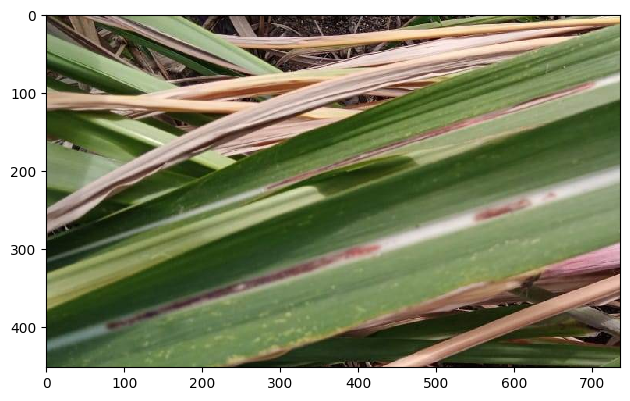

In [ ]:

og_image = imread(data_dir+'/RedRot/redrot (1).jpeg')
imshow(og_image);

In [ ]:
def multi_convolver(image, kernel, iterations):
    for i in range(iterations):
        image = convolve2d(image, kernel, 'same', boundary = 'fill',
                           fillvalue = 0)
    return image

In [ ]:
def convolver_rgb(image, kernel, iterations = 1):
    img_yuv = rgb2yuv(image)
    img_yuv[:,:,0] = multi_convolver(img_yuv[:,:,0], kernel,
                                     iterations)
    final_image = yuv2rgb(img_yuv)
    return final_image

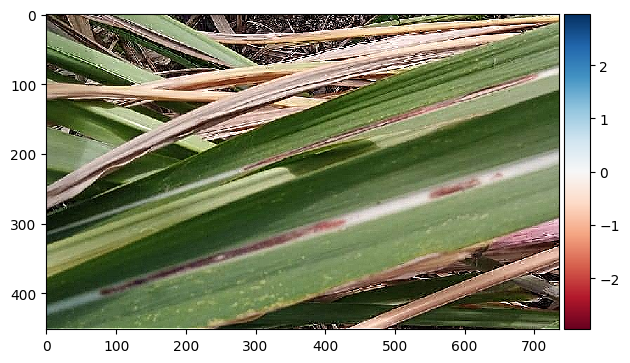

In [ ]:
final_image = convolver_rgb(og_image, sharpen, iterations = 1)
imshow(final_image);

In [ ]:

from PIL import Image
for i in categories:
    folder_path=os.path.join(data_dir, i) #path to each disease folder
    img_names=os.listdir(folder_path)   #all images in each disease folder
    for img_name in img_names:
        img_path=os.path.join(folder_path, img_name)
        if(img_path=='/content/data/RedRot_copy/.DS_Store' or img_path=='/content/data/Healthy_copy/.DS_Store' or img_path=='/content/data/RedRust_copy/.DS_Store'):
          continue
        img = Image.open(img_path)
        img = img.resize((224,224))
        img = np.array(img)
        img = convolver_rgb(img, sharpen, iterations = 1)
        data_list.append(img)
        labels_list.append(label_dict[i])

In [ ]:
data_list[0].shape

(224, 224, 3)

In [ ]:
lb = LabelEncoder()
labels_list = lb.fit_transform(labels_list)
labels_list = to_categorical(labels_list)

In [ ]:
data = np.array(data_list)
labels = np.array(labels_list)
print("Done")
print(data.shape)

Done
(1554, 224, 224, 3)


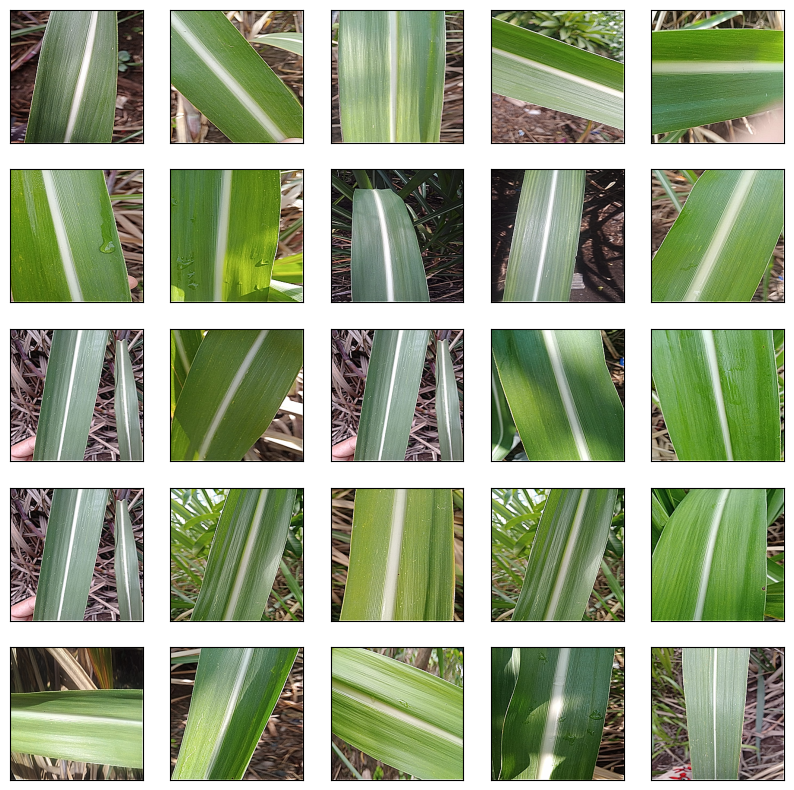

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data[np.random.randint(224)], cmap=plt.cm.binary)

plt.show()

In [ ]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [ ]:
print( trainX.shape, testX.shape, trainY.shape, testY.shape)

(1243, 224, 224, 3) (311, 224, 224, 3) (1243, 3) (311, 3)


In [ ]:
from keras.applications.densenet import DenseNet201, preprocess_input
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense ,Dropout
from keras.layers import Input

In [ ]:
base_model = DenseNet201(include_top=False,
                         input_shape=(224,224,3),
                         weights='imagenet',
                         pooling="avg"
                     )
# base_model = VGG16(include_top=False,
#                          input_shape=(224,224,3),
#                          weights='imagenet',
#                          pooling="avg"
#                      )

74836368/74836368 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.regularizers import l2

In [ ]:
base_model.trainable = False
image_input = Input(shape=(224, 224, 3))

x = base_model(image_input,training = False)

x = Dense(256,activation = "relu")(x)
x = Dropout(0.2)(x)

x = Dense(128,activation = "relu")(x)
x = Dropout(0.2)(x)

image_output = Dense(3,kernel_regularizer=l2(0.01),activation="softmax")(x) #output layer
#kernel Regulariser- SVM

model = Model(image_input,image_output)
model.compile(optimizer="adam",loss="squared_hinge",metrics=["accuracy"])
#loss function is square hinged- SVM

In [ ]:
from tensorflow.keras.utils import plot_model

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.4184 to fit



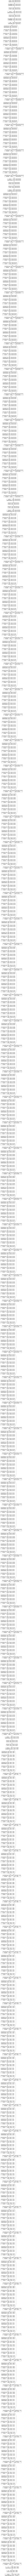

In [ ]:
plot_model(base_model, to_file = 'Densenet.png', show_shapes = True, show_layer_names = True)

In [ ]:
BS=32
EPOCHS=10

In [ ]:
history = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/10
38/38 [==============================] - 70s 1s/step - loss: 1.0748 - accuracy: 0.7126 - val_loss: 0.8676 - val_accuracy: 0.8842
Epoch 2/10
38/38 [==============================] - 19s 511ms/step - loss: 0.8852 - accuracy: 0.8637 - val_loss: 0.7962 - val_accuracy: 0.9453
Epoch 3/10
38/38 [==============================] - 19s 491ms/step - loss: 0.8353 - accuracy: 0.9158 - val_loss: 0.7859 - val_accuracy: 0.9518
Epoch 4/10
38/38 [==============================] - 21s 541ms/step - loss: 0.8159 - accuracy: 0.9182 - val_loss: 0.7562 - val_accuracy: 0.9743
Epoch 5/10
38/38 [==============================] - 18s 485ms/step - loss: 0.8226 - accuracy: 0.9108 - val_loss: 0.7575 - val_accuracy: 0.9614
Epoch 6/10
38/38 [==============================] - 18s 482ms/step - loss: 0.7988 - accuracy: 0.9273 - val_loss: 0.7980 - val_accuracy: 0.9260
Epoch 7/10
38/38 [==============================] - 20s 519ms/step - loss: 0.7823 - accuracy: 0.9438 - val_loss: 0.7334 - val_accuracy: 0.9775
Ep

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs))
print(accuracy_score(testY.argmax(axis=1),predIdxs))


[INFO] evaluating network...
10/10 [==============================] - 10s 808ms/step
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       104
           1       0.99      0.73      0.84       104
           2       0.76      1.00      0.86       103

    accuracy                           0.88       311
   macro avg       0.90      0.88      0.88       311
weighted avg       0.91      0.88      0.88       311

0.8810289389067524


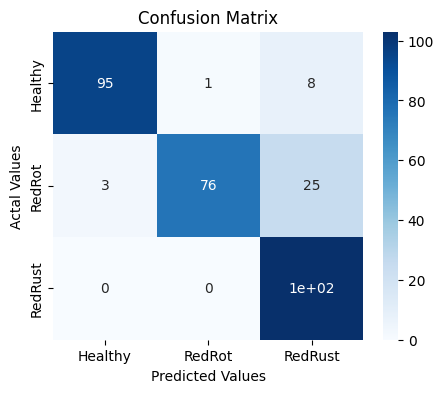

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(testY.argmax(axis=1), predIdxs)


cm_df = pd.DataFrame(cm,
                     index = ['Healthy','RedRot','RedRust'],
                     columns = ['Healthy','RedRot','RedRust'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


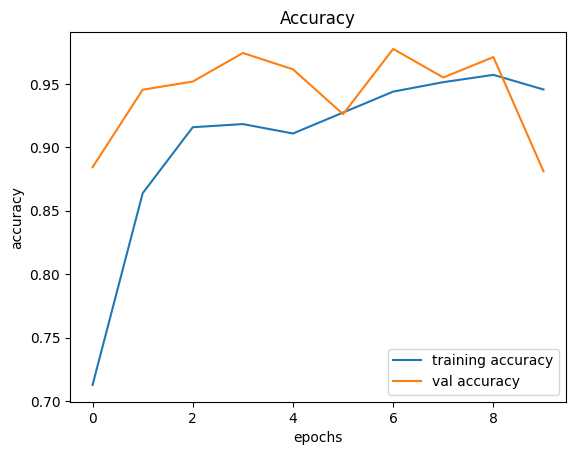

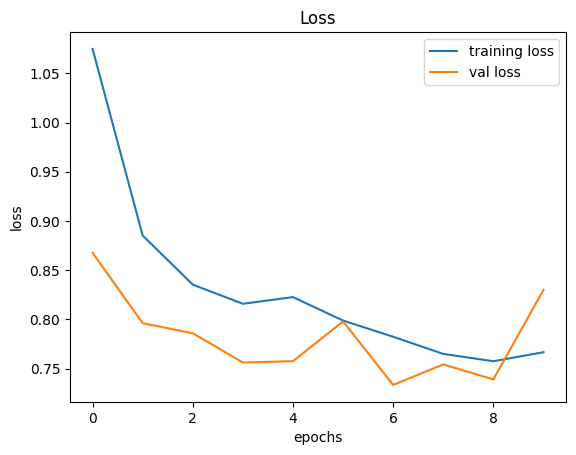

In [ ]:
import matplotlib.pyplot as plt
plt.figure(0)

plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:

from keras.preprocessing import image


img = image.load_img("/content/drive/My Drive/NewData/Healthy/1.jpg", target_size=(224,224))
x = image.img_to_array(img)
x=x/255
img = convolver_rgb(img, sharpen, iterations = 1)
x=x.reshape(224,224,3)
x = np.expand_dims(x, axis=0)


predi=model.predict(x)
print(predi)
classes_x=np.argmax(predi)
print(classes_x)

classes=["Healthy","Red Rot", "Red Rust"]
prediction_label=prediction_label=classes[classes_x]
if(prediction_label=="Healthy"):
  print("It is a Healthy Leaf")
else:
  print("Disease detected: "+prediction_label)

1/1 [==============================] - 3s 3s/step
[[9.9753582e-01 2.0744612e-03 3.8969290e-04]]
0
It is a Healthy Leaf


In [ ]:
model.save("DenseNetSVM_Model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#KNN Classifier
from PIL import Image

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def extract_features(img_paths):
    features = []
    for img_path in img_paths:
        x = preprocess_image(img_path)
        features.append(base_model.predict(x).flatten())
    return np.array(features)


img_paths=[]
for i in categories:
    folder_path=os.path.join(data_dir, i) #path to each disease folder
    img_names=os.listdir(folder_path)   #all images in each disease folder
    for img_name in img_names:
        img_path=os.path.join(folder_path, img_name)
        if(img_path=='/content/data/RedRot_copy/.DS_Store' or img_path=='/content/data/Healthy_copy/.DS_Store' or img_path=='/content/data/RedRust_copy/.DS_Store'):
          continue
        img_paths.append(img_path)

X_train, X_test, y_train, y_test = train_test_split(img_paths, labels, test_size=0.2, random_state=42)

In [ ]:
trainX_features=extract_features(X_train)
testX_features=extract_features(X_test)

1/1 [==============================] - 0s 34ms/step


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

error_rate=[]
k=0
min_k=1000
for i in range(1,40):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(trainX_features,y_train)
    pred_i=knn.predict(testX_features)
    mean=np.mean(pred_i!=y_test)
    if(mean<min_k):
        min_k=mean
        k=i
    error_rate.append(np.mean(pred_i!=y_test))

Text(0, 0.5, 'Error Rate')

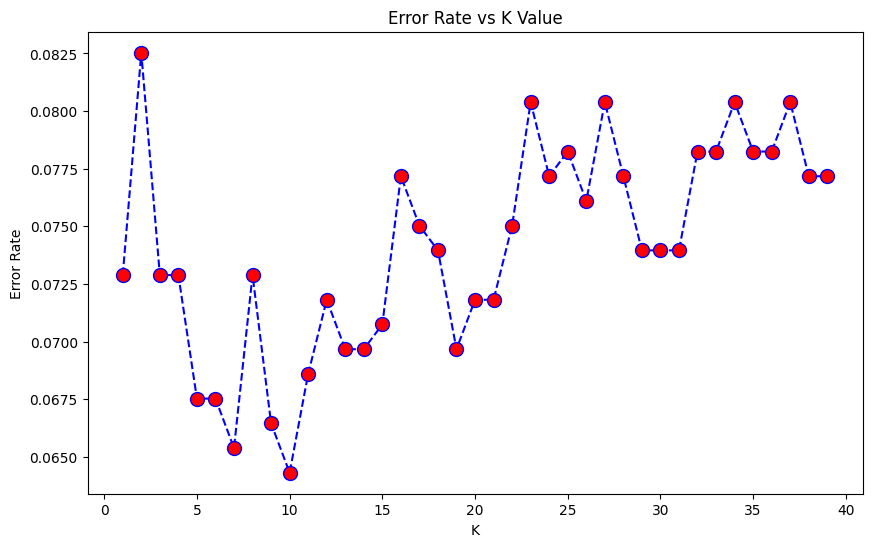

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue',linestyle='dashed',marker='o',markerfacecolor='red',markersize=10)
plt.title('Error Rate vs K Value')
plt.xlabel('K')
plt.ylabel("Error Rate")

In [ ]:
##KNN Metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
knn=KNeighborsClassifier(n_neighbors=1
                         )   #Avoid overfitting
knn.fit(trainX_features,y_train)
pred=knn.predict(testX_features)
print(classification_report(y_test,pred))
print(accuracy_score(y_test,pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94       105
           1       0.91      0.77      0.83       101
           2       0.87      0.92      0.89       105

   micro avg       0.89      0.89      0.89       311
   macro avg       0.89      0.89      0.89       311
weighted avg       0.89      0.89      0.89       311
 samples avg       0.89      0.89      0.89       311

0.8906752411575563


In [ ]:
print(confusion_matrix(y_test.argmax(axis=1),pred.argmax(axis=1)))

[[102   2   1]
 [  9  78  14]
 [  2   6  97]]


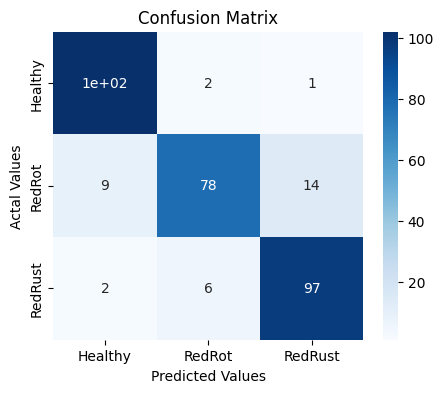

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

cm = confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1))


cm_df = pd.DataFrame(cm,
                     index = ['Healthy','RedRot','RedRust'],
                     columns = ['Healthy','RedRot','RedRust'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
import pickle
knnPickle = open('knnpickle_file_data3', 'wb')

# source, destination
pickle.dump(knn, knnPickle)

# close the file
knnPickle.close()

In [ ]:
## RandomForest Classifer
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier()

grid_space={'max_depth':[1,2,3,4,5],
              'n_estimators':[10,100,200],
              'max_features':['sqrt','log2'],
              'min_samples_leaf':[1,2,3],
              'min_samples_split':[2,3,4]
           }

In [ ]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(rf,param_grid=grid_space,cv=5,scoring='accuracy',error_score='raise')
model_grid = grid.fit(trainX_features,y_train)

In [ ]:
print('Best hyperparameters are: '+str(model_grid.best_params_))
print('Best score is: '+str(model_grid.best_score_))

Best hyperparameters are: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 200}
Best score is: 0.8624206503433088


In [ ]:
rf=RandomForestClassifier(max_depth=5,max_features='sqrt',min_samples_leaf=3,min_samples_split=3,n_estimators=100)

In [ ]:
rf.fit(trainX_features,y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=3, min_samples_split=3)

In [ ]:
pred=rf.predict(testX_features)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
print(classification_report(pred,y_test))
print(accuracy_score(pred,y_test))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94        96
           1       0.86      0.97      0.91        90
           2       0.81      1.00      0.89        85

   micro avg       0.86      0.98      0.91       271
   macro avg       0.86      0.98      0.91       271
weighted avg       0.86      0.98      0.91       271
 samples avg       0.86      0.86      0.86       271

0.8553054662379421


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


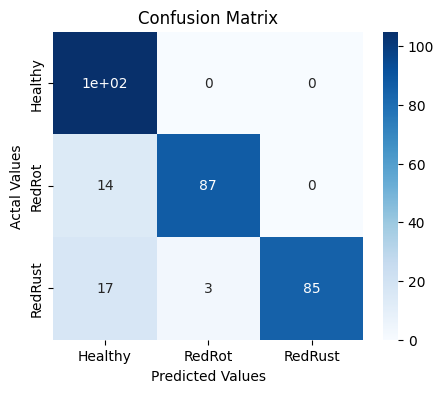

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1))


cm_df = pd.DataFrame(cm,
                     index = ['Healthy','RedRot','RedRust'],
                     columns = ['Healthy','RedRot','RedRust'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()